In [2]:
#Pkg.build("Plots")
using Plots
using StatsBase
using Distributions
using GLM 
using Lathe
using DataFrames
using MLBase 
using ROCAnalysis 
using LinearAlgebra
using CSV
using LsqFit

Read from Porton Down paper the sigmoidal of Innova vs Ct

In [3]:
VLrange_low = 1:7
VLrange_upp = 2:8 
pos = [4, 15, 35, 64, 82, 37, 11]
tots = [17, 46, 54, 72, 85, 38, 11]
generated_cts = vcat(fill.(0.5 .* (VLrange_upp .+ VLrange_low),pos)...)
generated_cts = vcat(generated_cts,vcat(fill.(0.5 .* (VLrange_upp .+ VLrange_low),tots .- pos)...))
generated_results = vcat(ones(Bool,sum(pos)),zeros(Bool,sum(tots .- pos)))
dfPD = DataFrame(Ct=generated_cts, results=generated_results)
fm = @formula(results ~ Ct) 
probit = glm(fm, dfPD, Binomial(), ProbitLink())
logit = glm(fm, dfPD, Binomial(), LogitLink())
cloglog = glm(fm, dfPD, Binomial(), CloglogLink())
print(deviance(probit),' ',deviance(logit), ' ',deviance(cloglog))
b = coef(logit)
print('\n',b)

235.13870892967626 234.31078810693276 238.52105622208197
[-3.592588611925298, 1.2224082302454882]

Get from Hellewell PCR positivity curve

In [4]:
df = DataFrame(CSV.File("../../../pcr-profile/PCR_curve_summary.csv"))

,days_since_infection,median,lower_95,upper_95
,Float64,Float64,Float64,Float64
1,0.0,0.00492372,0.00040002,0.0199772
2,0.1,0.00613475,0.00052989,0.0237458
3,0.2,0.00760506,0.000689322,0.0289895
4,0.3,0.0093669,0.000912243,0.0348879
5,0.4,0.0115655,0.00116604,0.0426077
6,0.5,0.014306,0.00153562,0.0529108
7,0.6,0.0176253,0.00202423,0.0659616
8,0.7,0.0214933,0.00262086,0.0825766
9,0.8,0.0262523,0.00331922,0.101908


Fit VL post symptom onset to Singanayagam Eurosurveillance data for culture positive cases

235.13870892967626 234.31078810693276 238.52105622208197


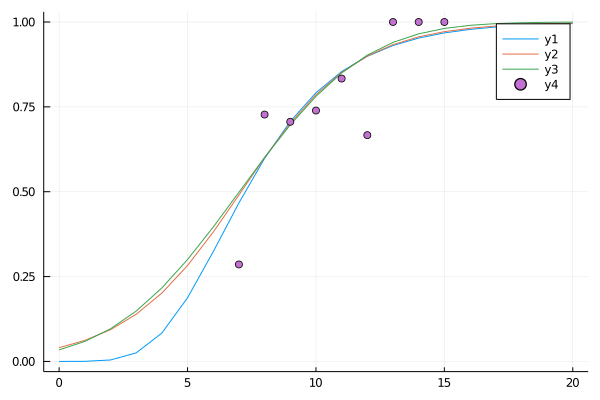

In [5]:
DFSO = collect(7:15)
observed = [10,9,10,6,1,1,0,0,0]
tested = [14,33,34,23,6,3,4,2,2]
generated_cps = vcat(ones(Bool,sum(observed)),zeros(Bool,sum(tested) - sum(observed)))
generated_dfsos = vcat(fill.(DFSO,observed)...)
generated_dfsos = vcat(generated_dfsos, fill.(DFSO,tested .- observed)...)
dfCPbinary = DataFrame(Dfso=generated_dfsos, results=generated_cps)
dfCPcont = DataFrame(Dfso=DFSO, results=Float64.(observed ./ tested))
fm = @formula(results ~ Dfso) 
cp_probit = glm(fm, dfCPbinary, Binomial(), ProbitLink())
cp_logit = glm(fm, dfCPbinary, Binomial(), LogitLink())
cp_cloglog = glm(fm, dfCPbinary, Binomial(), CloglogLink())

print(deviance(probit),' ',deviance(logit), ' ',deviance(cloglog),'\n')
DFSOtest = collect(0:20)
testDF = DataFrame(Dfso=DFSOtest)
plot(DFSOtest, 1 .- predict(cp_cloglog,testDF))
plot!(DFSOtest, 1 .- predict(cp_logit,testDF))
plot!(DFSOtest, 1 .- predict(cp_probit,testDF))
scatter!(DFSO, 1 .- observed./tested)

cdf = exp(-exp(c[2]*DFSO + c[1]))
invcdf = (log(-log(cdf)) - c[1])/c[2]

LsqFit.LsqFitResult{Array{Float64,1},Array{Float64,1},Array{Float64,2},Array{Float64,1}}([5.1999999998283535, 2.9797987603556417], [-1.7320485113945425, 2.1901562783214823, 1.1999999998283535, -0.7901562786647753, -0.8679514889487514], [1.000000000005791 -2.326347874023251; 1.000000000005791 -0.6744897501890601; 1.000000000005791 0.0; 1.000000000005791 0.6744897502136715; 1.000000000005791 2.326347874023251], true, Float64[])

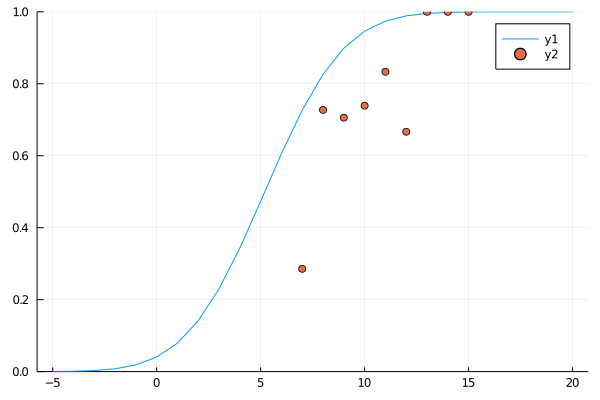

In [6]:
@. decaymodel(x,p) = quantile(Normal(p[1],p[2]),x)
xdata = [0.01,0.25,0.5,0.75,0.99]
ydata = [0.0,1.0,4.0,8.0,13.0] 
p0 = [1.0,1.0]
lb = [0.001, 0.001]
ub = [Inf, Inf]
fit = curve_fit(decaymodel, xdata, ydata, p0, lower=lb, upper=ub)
pdfit = coef(fit)
print(fit)
xd = collect(-5:20)
plot(xd,cdf(Normal(pdfit[1],pdfit[2]),xd),ylim=(0,1))
scatter!(DFSO, 1 .- observed./tested)
#plot(xd .+ pdfit[3],pdf(Weibull(pdfit[1],pdfit[2]),xd .+ pdfit[3]))
# function gen_decay_time(dinit::Float64)
#     c = coef(cp_cloglog)
#     d = dinit
#     while d < 0
#         rand_num = rand()
#         d = (log(-log(rand_num)) - c[1])/c[2]
#     end
#     return d
# end




Assume there is some actual viral load, which is given in log10 copies / ml.

Assume there is some sigmoidal probability that swab acquires a +ve sample (this dependence is completely fabricated).

PCR is 1:1 with swab positivity above absolute cutoff

LFD has failure rate compared to PCR determined by Porton Down estimates. This seems sensible given very low "false positive" rates.

Assume peak infectivity is correlated to peak viral load through the odds ratio relation in Marks' Catalonia paper. Allow some noise around this.

VL trajectories from Bayesian model fitted in Kissler paper (NBA players)

In [165]:
peakVL_mean = 7.533
peakVL_sd = 1.164
mean_asymp = 0.5
pasymp_vl7 = 0.65
pasymp_vl89 = 0.5
pasymp_vl10 = 0.35
asymp_frac = cdf(Normal(peakVL_mean,peakVL_sd),7.0)*pasymp_vl7 + 
    (cdf(Normal(peakVL_mean,peakVL_sd),9.0) - cdf(Normal(peakVL_mean,peakVL_sd),7.0))*pasymp_vl89 +
    (1 - cdf(Normal(peakVL_mean,peakVL_sd),9.0))*pasymp_vl10
inf_sd = 0.5
PIsigma = 0.5
PImu = -0.5*PIsigma^2

function Prob_is_sampled(VL::Float64, disp::Float64, sens_max::Float64, VL0::Float64)
    return sens_max*exp(-exp(disp*(VL0-VL)))
end

function PCR_positivity(VL::Float64, disp::Float64, sens_max::Float64, VL0::Float64)
    if VL > 0.0
        return Prob_is_sampled(VL,disp,sens_max,VL0)
    else
        return 0.0
    end
end

function LFD_positivity(VL::Array{Float64,1}, disp::Float64, sens_max::Float64, VL0::Float64)
    dfsamp = DataFrame(Ct=VL)
    out = predict(logit,dfsamp)
    p = Prob_is_sampled.(VL,Ref(disp),Ref(sens_max),Ref(VL0)) .* out
    p[VL .< 0.0] .= 0
    return p
end

function Peak_Infectivity(VL::Float64, symp::Bool, VLscale::Float64, VL0::Float64, x::Float64)
    value = x^(VL - VLscale)
    ascale = mean_asymp*asymp_frac + (1 - asymp_frac)
    r = rand(LogNormal(PImu,PIsigma))
    if !symp 
        r = mean_asymp * r
    end
    return r*value/ascale
end
VLrange = 0.0:0.1:12.0
VLmed = 1.5
VL0 = 2.5
VLscale = 7.53
X = 1.3
SM = 0.97
D = 1.0
Ptest = PCR_positivity.(VLrange, Ref(D), Ref(SM), Ref(VLmed))
Itest = Peak_Infectivity.(VLrange, ones(Bool,length(VLrange)), Ref(VLscale), Ref(VL0), Ref(X))
Ltest = LFD_positivity(collect(VLrange), D, SM, VLmed)
Plots.plot(VLrange, Ptest,label="PCR",xlim=(0,12),ylim=(0,1))
plot1 = Plots.plot!(VLrange, Ltest,label="LFD",xlim=(0,12),ylim=(0,1),xlabel="Viral load (log10 copies/ml)",
    ylabel="Probability of positive test",title="(a)")
#plot2 = Plots.scatter(VLrange, Itest,label="Relative Peak Infectivity",xlim=(0,12),ylim=(0,10.0))
plot3 = Plots.plot(VLrange, Ltest ./ Ptest,xlim=(0,10),ylim=(0,1),xlabel="Viral load (log10 copies/ml)",
    ylabel="Probability of positive LFD given +ve PCR",title="(b)")
plot(plot1,plot3,layout=(1,2),size=(900,350),margin=5Plots.mm)
Plots.savefig("LFD_PCR_VLdep.png")

In [150]:
ctmean_kissler = 22.4
ctsd_kissler = 4.2
function ct_toVL_kissler(ct)
    return log10(250) + (ct - 40.93733)/(-3.60971)
end

function ct_toVL_peto(ct)
   return VL = 11.19 - 0.304*(ct - 4.4) 
end

VLnegative = ct_toVL_kissler(40)
VLneg2 = ct_toVL_peto(37)
print(ct_toVL_kissler(ctmean_kissler), ' ', ctsd_kissler/3.60971, '\n')
print(VLnegative,' ', VLneg2)


7.533347008126288 1.1635283720852923
2.6576090679593496 1.2795999999999985

Let's generate some profiles at random, assuming that VL peaks on average at 
symptom time but with about half S.D than symptom time

In [151]:
dt = 0.1
t = 0:dt:30
N=1000
VLinfcutoff = 0.0
PeakCts = rand(Normal(ctmean_kissler,ctsd_kissler),N)  #kissler data
PVLs = ct_toVL_kissler.(PeakCts)
OTs = rand(Gamma(1.1,1.0/0.7),N)
PTs = rand(Gamma(2.3,1.0/0.7),N)
DTs = rand(Gamma(2.4,1.0/0.3),N)    #gen_decay_time.(-ones(N))
Plots.histogram(PVLs,bins=50,label="Peak VL value",xlim=(4,12),normed=true,xlabel="rVL log10 copies/ml")
x1 = collect(4.:0.1:12.0)
plot1 = Plots.plot!(x1,pdf(Normal(7.53, 1.16),x1),w=3,label=:none,title="(a)")
Plots.histogram(PTs,label="Time to peak VL",xlim=(0,15),normed=true,xlabel="Days")
x2 = collect(0.0:0.1:15.0)
plot2 = Plots.plot!(x2,pdf(Gamma(2.3,1.0/0.7),x2),w=3,label=:none,title="(b)")
Plots.histogram(DTs,label="Time from peak VL to 0",xlim=(0,30),normed=true,xlabel="Days")
x3 = 0.0:0.1:30.0
plot3 = Plots.plot!(x3,pdf(Gamma(2.4,1.0/0.3),x3),w=3,label=:none,title="(c)")
Plots.plot(plot1,plot2,plot3,layout=(1,3),size=(1000,350),margin=5Plots.mm)

Plots.savefig("VL_distributions.png")

In [152]:
using Random


function generate_asymptomatics(VL::Array{Float64,1})
    #randomly generate if people are asymptomatic
    nr = 1:length(VL)
    nVL7 = nr[VL .< 7]
    nVL89 = nr[(VL .>= 7) .* (VL .<= 9)]
    nVL10 = nr[VL .> 9]
    return vcat(randsubseq(nVL7,pasymp_vl7),randsubseq(nVL89,pasymp_vl89),
                randsubseq(nVL10,pasymp_vl10))
end
As = generate_asymptomatics(PVLs)
symp = ones(Bool,length(PVLs))
symp[As] .= false
print(mean(PVLs[As]),' ', mean(PVLs[symp]),'\n')
j0 = Peak_Infectivity.(PVLs, symp, Ref(VLscale), Ref(VL0), Ref(X))
print(mean(j0[As]),' ', mean(j0[symp]),'\n')
print(length(As)/length(PVLs))
scatter(PVLs[As], j0[As],label="Asymp")
scatter!(PVLs[symp], j0[symp],xlabel="Peak VL (log10 copies/ml)", ylabel="Peak infectivity",label="Symp")
Plots.savefig("Inf_VL_relation.png")

7.347127807615035 7.846426727847561
0.686405378315697 1.5317315958335822
0.526

Plot mean test positivity profiles

In [153]:

v = zeros(N,length(t))
for n in 1:N
    m_up = PVLs[n]/PTs[n]
    m_down = PVLs[n]/DTs[n]
    cond1 = ((t .> OTs[n]) .* (t .<= OTs[n] + PTs[n]))
    v[n,cond1] = m_up .* (t[cond1] .- OTs[n])
    cond2 = ((t .> OTs[n] + PTs[n]) .* (t .<= OTs[n] + PTs[n] + DTs[n]))
    v[n,cond2] = PVLs[n] .- m_down .* (t[cond2] .- OTs[n] .- PTs[n])
end

301 301

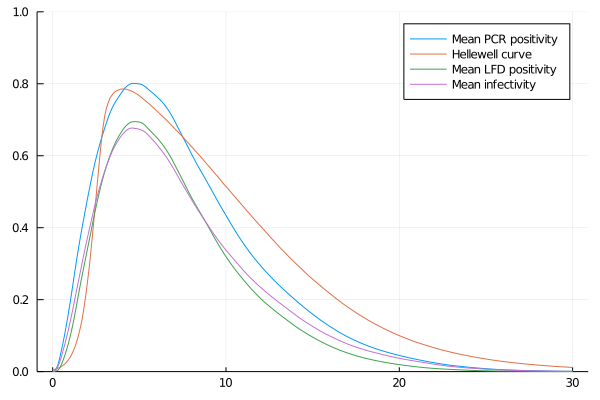

In [169]:
nr = 1:N
selection = nr[PVLs .> VLinfcutoff]
j = zeros(N,length(t))
p = zeros(N,length(t))
LFDp = zeros(N,length(t))
j[v .> VLinfcutoff] = (v[v .> VLinfcutoff] .- VLinfcutoff)
j = Diagonal(j0 ./(PVLs .- VLinfcutoff)) * j 
p = PCR_positivity.(v, Ref(D), Ref(SM), Ref(VLmed))
for n in 1:N
    LFDp[n,:] = LFD_positivity(v[n,:], D, SM, VLmed)
end
print(length(t), ' ', length(mean(p,dims=1)))
Plots.plot(t,transpose(mean(p,dims=1)),ylim=(0,1),label="Mean PCR positivity")
Plots.plot!(t,df["median"],ylim=(0,1),label="Hellewell curve")
Plots.plot!(t,transpose(mean(LFDp,dims=1)),ylim=(0,1),label="Mean LFD positivity")
Plots.plot!(t,transpose(mean(j,dims=1)),ylim=(0,1),label="Mean infectivity")

Plot the viral loads

8

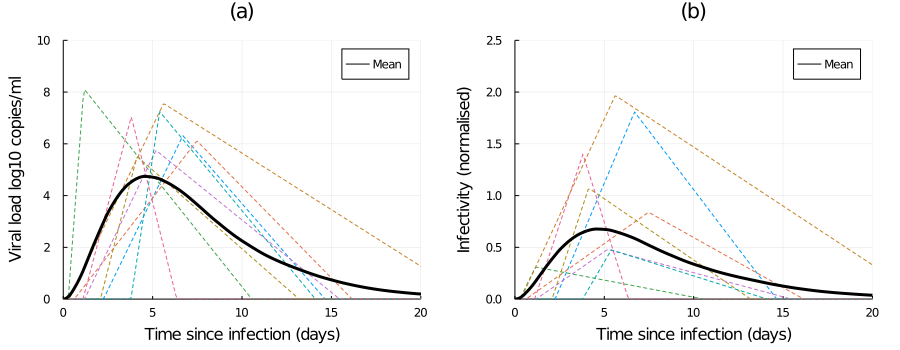

In [170]:
selected = 44:130:1000
print(length(selected))
Plots.plot(t,transpose(v[selected,:]),xlim=(0,20),ylim=(0,10),s=:dash,alpha=1,label=:none)
plot1 = Plots.plot!(t,transpose(mean(v,dims=1)),c="black",lw=3,label="Mean",xlabel="Time since infection (days)",
ylabel="Viral load log10 copies/ml",title="(a)")

Plots.plot(t,transpose(j[selected,:]),xlim=(0,20),ylim=(0,2.5),s=:dash,alpha=1.0,label=:none)
plot2 = Plots.plot!(t,transpose(mean(j,dims=1)),ylim=(0,2.5),c="black",lw=3,label="Mean",
    xlabel="Time since infection (days)", ylabel="Infectivity (normalised)",title="(b)")
Plots.plot(plot1,plot2,layout=(1,2),size=(900,350),margin=5Plots.mm)
#Plots.savefig("VL_trajectories.png")

Plot the PCR Test Positivity and Plot LFD positivity

In [156]:

Plots.plot(t,transpose(p[selected,:]),ylim=(0,1),s=:dash,alpha=1,label=:none)
Plots.plot!(t,transpose(mean(p,dims=1)),xlim=(0,20),ylim=(0,1),c="black",lw=3,label="Mean")
plot1 = Plots.plot!(df["days_since_infection"],df["median"],lw=3,c="red",label="Hellewell",xlabel="Time since infection (days)",
ylabel="PCR positive test probability",title="(a)")

Plots.plot(t,transpose(LFDp[selected,:]),xlim=(0,20),ylim=(0,1),s=:dash,alpha=1,label=:none)
plot2 = Plots.plot!(t,transpose(mean(LFDp,dims=1)),ylim=(0,1),c="black",lw=3,label="Mean",
    xlabel="Time since infection (days)", ylabel="LFD positive test probability",title="(b)")
Plots.plot(plot1,plot2,layout=(1,2),size=(900,350),margin=5Plots.mm)
Plots.savefig("Test_positivity.png")

Plot the infectivity profiles

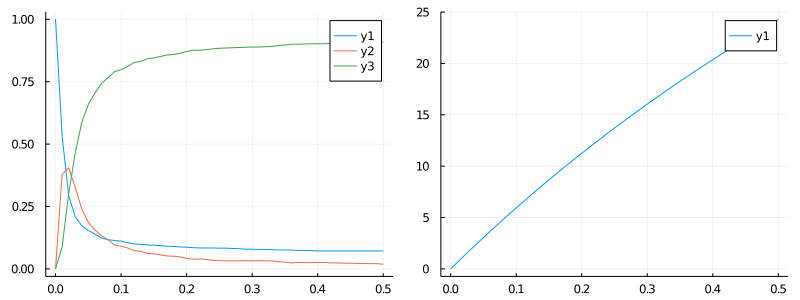

In [205]:
beta = 0.0:0.01:0.5
FR0 = zeros(length(beta))
FR1 = zeros(length(beta))
FRg1 = zeros(length(beta))
Rav = zeros(length(beta))
for (i,bt) in enumerate(beta)
    Ppcpd = 1 .- exp.(- bt .* j)
    FR0[i] = sum(sum(Ppcpd,dims=1)*dt .< 0.05)/N
    FR1[i] = (sum((sum(Ppcpd,dims=1)*dt .>= 0.05) .* (sum(Ppcpd,dims=1)*dt .< 0.15)))/N
    FRg1[i] = sum(sum(Ppcpd,dims=1)*dt .>= 0.15)/N
    Rav[i] = mean(sum(Ppcpd,dims=1)*dt).*10
end
plot(beta, FR0)
plot!(beta, FR1)
p1 = plot!(beta, FRg1)
p2 = plot(beta, Rav)
plot(p1,p2,layout=(1,2),size=(800,300))

Problem is that test positive rates are much better than the average. 

Can show this by e.g. multiplying test positive rates by infectious prob. Then averaging and normalising by mean infection prob

In [180]:
Ppcpd = 1 .- exp.(- 0.1 .* j)
we = mean(p.*Ppcpd,dims=1)./mean(Ppcpd,dims=1)
we1 = mean(LFDp.*Ppcpd,dims=1)./mean(Ppcpd,dims=1)

1×1000 Array{Float64,2}:
 0.633617  0.738922  0.517166  0.73635  …  0.764893  0.666608  0.666981

Then compare this to same calculation but for the median profiles

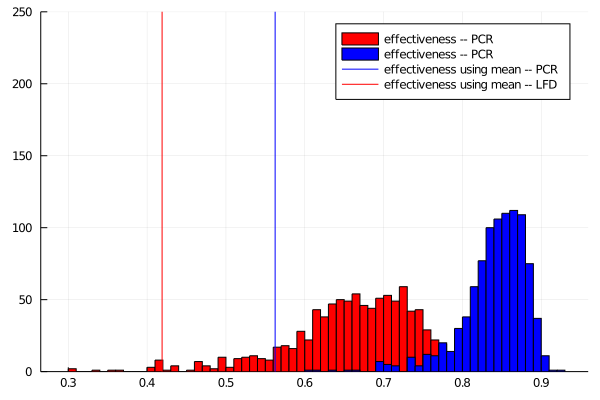

In [181]:
wemean = mean(mean(p,dims=2).*mean(Ppcpd,dims=2),dims=1) / mean(Ppcpd)
we1mean = mean(mean(LFDp,dims=2).*mean(Ppcpd,dims=2),dims=1) / mean(Ppcpd)
Plots.histogram(transpose(we1),bins=50,c="red",label="effectiveness -- PCR")
Plots.histogram!(transpose(we),bins=50,c="blue",label="effectiveness -- PCR")
Plots.plot!([wemean;wemean],[0;N],c="blue",label="effectiveness using mean -- PCR")
Plots.plot!([we1mean;we1mean],[0;N],c="red",ylim=(0,250),label="effectiveness using mean -- LFD")

The amount the mean profiles actually differ will depend on noise and the 
interdependence of these processes that are assumed
to have 1:1 relationships (like Ct and infectivity)

1.2432290637117596